In [3]:
%matplotlib notebook 

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from services.StockService import StockService
import seaborn as sns
sns.set()

In [4]:
# df = pd.read_csv('../dataset/GOOG-year.csv')
# df.head()

df = StockService.get_stock_from_datestrings('gs')

    ticker        date    open    high     low   Close     volume  dividends  \
738     GS  2018-09-04  237.76  238.12  234.59  237.66  2078921.0        0.0   
739     GS  2018-09-05  237.01  239.45  236.17  237.56  2091422.0        0.0   
740     GS  2018-09-06  237.00  238.63  233.88  234.52  2627965.0        0.0   
741     GS  2018-09-07  235.05  235.64  232.68  233.91  1928448.0        0.0   
742     GS  2018-09-10  235.01  235.50  231.74  231.91  1925816.0        0.0   

     closeunadj lastupdated  
738      237.66  2018-09-04  
739      237.56  2018-09-05  
740      234.52  2018-09-06  
741      233.91  2018-09-07  
742      231.91  2018-09-10  


In [5]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 512, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, self.action_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [6]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

W0714 14:01:32.482901 14044 deprecation.py:323] From <ipython-input-5-28bed545c0f8>:26: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0714 14:01:32.487903 14044 deprecation.py:506] From c:\users\chris\workspaces\stock-predictor\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


epoch: 10, total rewards: -26.810000.3, cost: 0.613934, total money: 9973.190000
epoch: 20, total rewards: -70.830000.3, cost: 0.275347, total money: 9929.170000
epoch: 30, total rewards: -68.400000.3, cost: 0.230278, total money: 9931.600000
epoch: 40, total rewards: -64.400000.3, cost: 0.172855, total money: 9935.600000
epoch: 50, total rewards: -66.890000.3, cost: 0.182787, total money: 9933.110000
epoch: 60, total rewards: -67.610000.3, cost: 0.121037, total money: 9932.390000
epoch: 70, total rewards: -70.170000.3, cost: 0.204944, total money: 9929.830000
epoch: 80, total rewards: -67.610000.3, cost: 0.232772, total money: 9932.390000
epoch: 90, total rewards: -67.610000.3, cost: 0.077403, total money: 9932.390000
epoch: 100, total rewards: -67.610000.3, cost: 0.067700, total money: 9932.390000
epoch: 110, total rewards: -53.720000.3, cost: 0.167301, total money: 9946.280000
epoch: 120, total rewards: -59.310000.3, cost: 0.179294, total money: 9940.690000
epoch: 130, total rewards

In [7]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 16: buy 1 unit at price 228.880000, total balance 9771.120000
day 17: buy 1 unit at price 227.740000, total balance 9543.380000
day 18, sell 1 unit at price 224.240000, investment -2.027263 %, total balance 9767.620000,
day 19, sell 1 unit at price 225.330000, investment -1.058224 %, total balance 9992.950000,
day 34: buy 1 unit at price 221.600000, total balance 9771.350000
day 35, sell 1 unit at price 218.560000, investment -1.371841 %, total balance 9989.910000,
day 36: buy 1 unit at price 209.180000, total balance 9780.730000
day 38, sell 1 unit at price 212.360000, investment 1.520222 %, total balance 9993.090000,
day 46: buy 1 unit at price 231.280000, total balance 9761.810000
day 47: buy 1 unit at price 231.650000, total balance 9530.160000
day 48, sell 1 unit at price 222.650000, investment -3.731408 %, total balance 9752.810000,
day 49, sell 1 unit at price 206.050000, investment -11.051155 %, total balance 9958.860000,
day 62: buy 1 unit at price 190.690000, total balanc

<IPython.core.display.Javascript object>


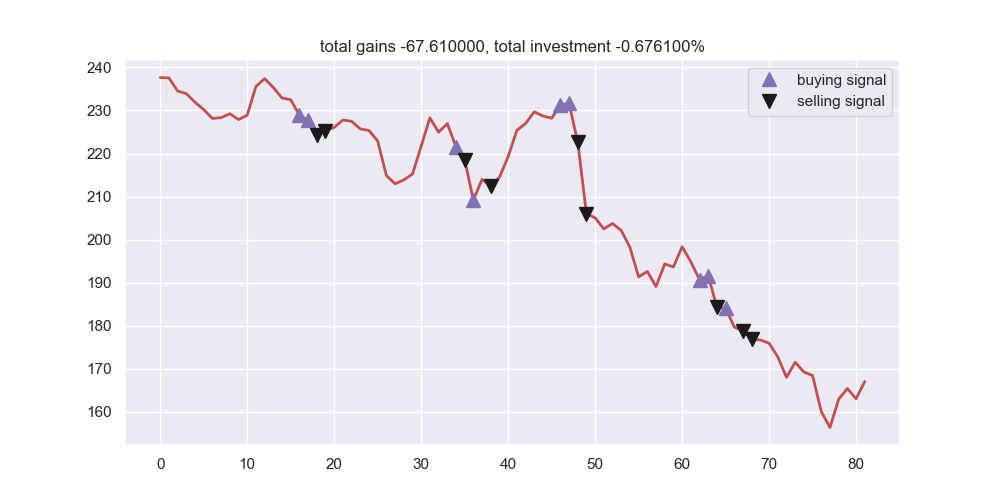

In [11]:
fig = plt.figure(figsize = (10,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()